# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2019 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original GAN example from:

Links:
[Keras-GAN] https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
</pre>


In [0]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np


Using TensorFlow backend.


In [0]:
class GAN_image():

  # diszkriminátor hálózat: képről bináris döntés,
  # hogy valódi vagy hamis
  def build_discriminator(self):
    model = Sequential()
    
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) # LeakyReLU, a sima ReLU helyett
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  # generátor hálózat: zajból kép generálás
  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) # BatchNorm: előadáson
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
    # látens dimenzió: belső reprezentáció mérete
    self.latent_dim = 100
    
    optimizer = Adam(0.0002, 0.5)
    
    # diszkriminátor build és compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    
    # generátor build
    self.generator = self.build_generator()
    
    # generátor: zaj bemenetből képet készít
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    
    # együttes modell - itt csak a generátort tanítjuk
    # (a diszkriminátorra már volt build fent,
    # így csak a közös hálózatban lévő diszkriminátor nem lesz tanítható)
    self.discriminator.trainable = False
    
    # diszkriminátor: generált képekről eldönti, hogy valódiak-e
    validity = self.discriminator(img)
    
    # együttes modell
    # cél: a generátor megtanulja, hogyan csaphatja be a diszkriminátort
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)

  


In [0]:
# tanítás paraméterek
steps = 30000
batch_size = 128
sample_interval = 50

In [0]:
# az első summary a diszkriminátor hálózat,
#  (kép -> bináris döntés)
# a második summary a generátor hálózatra vonatkozik
#  (mintavételezett zaj -> kép)

gan = GAN_image()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_____________________________________________

In [0]:
# adatok betöltése
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# skálázás -1 és 1 közé
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# generált képek kirajzolása

from IPython import display

def plot_images(gan, step):
  r, c = 2,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # átskálázás: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



0 loss_D 0.59664315 loss_G 0.7531752


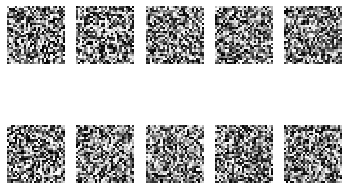

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 loss_D 0.11548579 loss_G 3.4184723


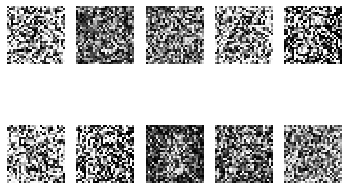

200 loss_D 0.5121078 loss_G 2.0257761


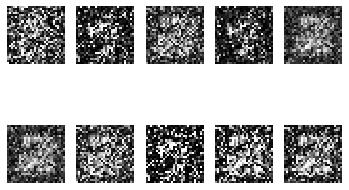

300 loss_D 0.6683867 loss_G 0.6586624


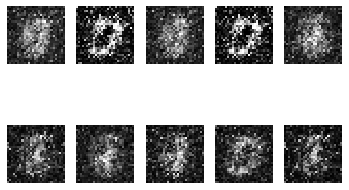

400 loss_D 0.66961074 loss_G 0.66625345


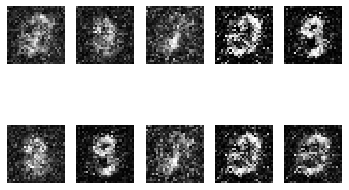

500 loss_D 0.6164607 loss_G 0.7540568


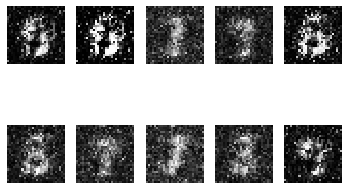

600 loss_D 0.58816344 loss_G 0.82336336


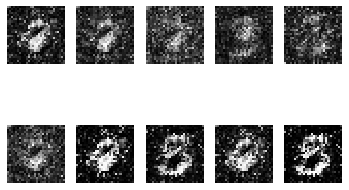

700 loss_D 0.59695023 loss_G 0.8788189


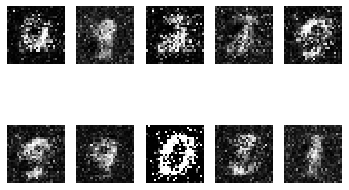

800 loss_D 0.5642426 loss_G 1.0050892


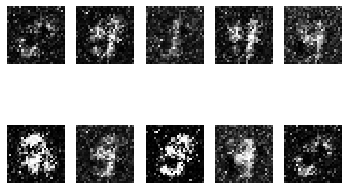

900 loss_D 0.62082064 loss_G 1.0037796


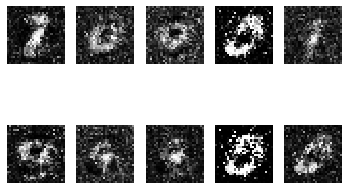

1000 loss_D 0.5893836 loss_G 1.0789123


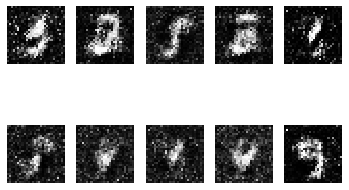

1100 loss_D 0.5970271 loss_G 1.0176724


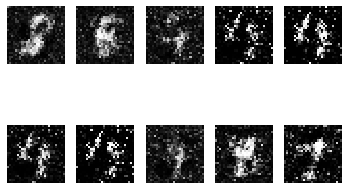

1200 loss_D 0.60447145 loss_G 0.99315464


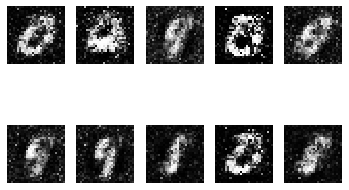

1300 loss_D 0.57525295 loss_G 0.9749496


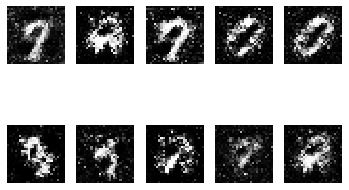

1400 loss_D 0.58431584 loss_G 1.0099821


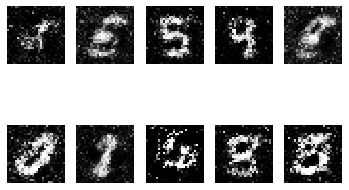

1500 loss_D 0.58239746 loss_G 1.0238054


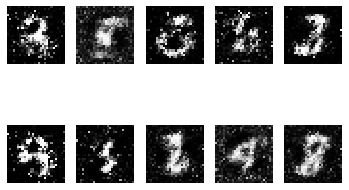

1600 loss_D 0.61868274 loss_G 0.9225022


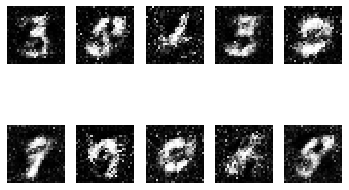

1700 loss_D 0.62231016 loss_G 0.9497226


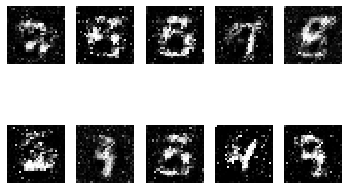

1800 loss_D 0.6091628 loss_G 0.9068218


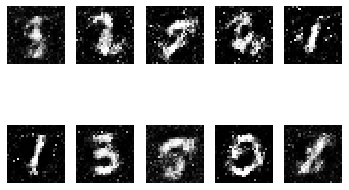

1900 loss_D 0.59627587 loss_G 0.8955891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


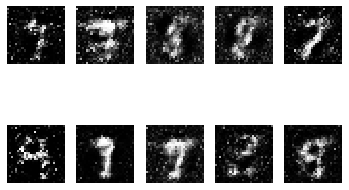

2000 loss_D 0.5990052 loss_G 0.9449134


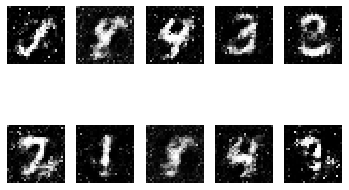

2100 loss_D 0.6098317 loss_G 0.9087237


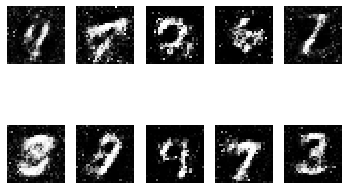

2200 loss_D 0.62493527 loss_G 0.9117647


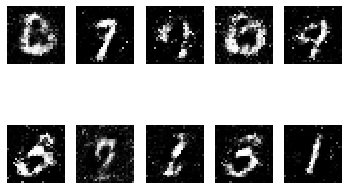

2300 loss_D 0.61275625 loss_G 0.9221078


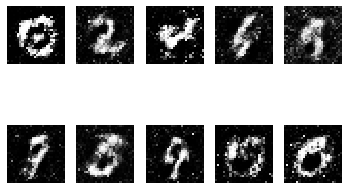

2400 loss_D 0.62326586 loss_G 0.9106277


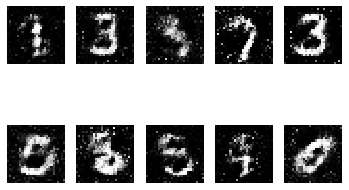

2500 loss_D 0.6247275 loss_G 0.87002635


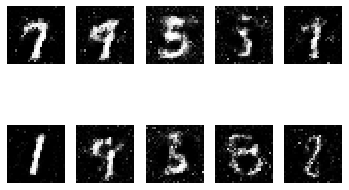

2600 loss_D 0.6079434 loss_G 0.90150875


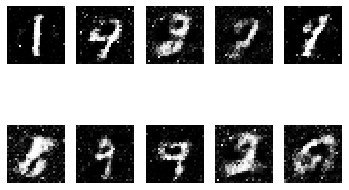

2700 loss_D 0.6243094 loss_G 0.90217936


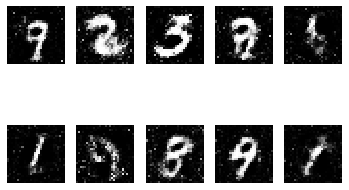

2800 loss_D 0.61563814 loss_G 0.8930031


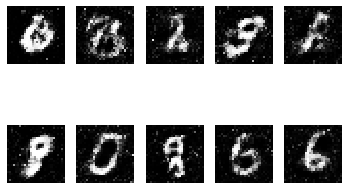

2900 loss_D 0.60887426 loss_G 0.93096256


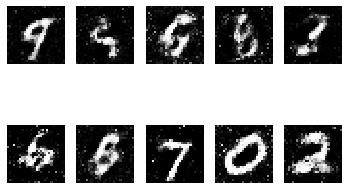

3000 loss_D 0.61225533 loss_G 0.93660396


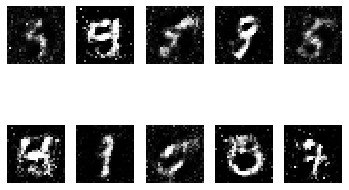

3100 loss_D 0.6441152 loss_G 0.8645401


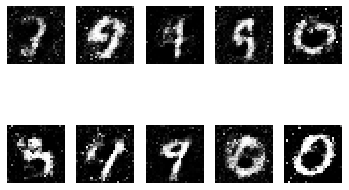

3200 loss_D 0.6425558 loss_G 0.8634232


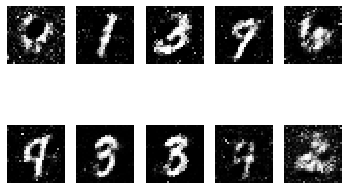

3300 loss_D 0.61946344 loss_G 0.902823


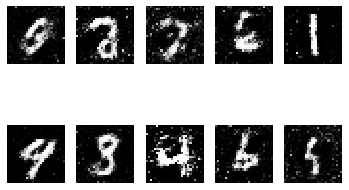

3400 loss_D 0.63659996 loss_G 0.8777666


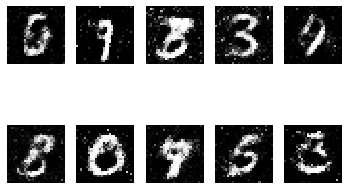

3500 loss_D 0.63845754 loss_G 0.87446654


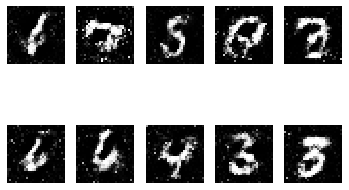

3600 loss_D 0.65689725 loss_G 0.8561485


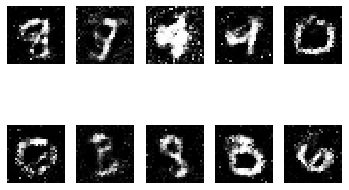

3700 loss_D 0.63755953 loss_G 0.9019438


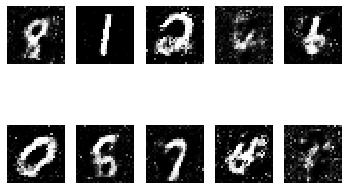

3800 loss_D 0.6425803 loss_G 0.87523115


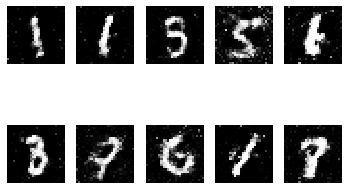

3900 loss_D 0.645223 loss_G 0.9630027


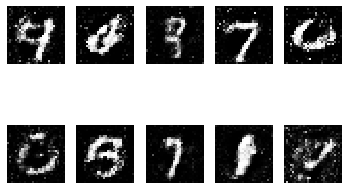

4000 loss_D 0.6434597 loss_G 0.8802612


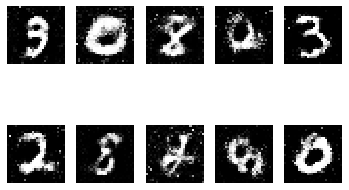

4100 loss_D 0.64580774 loss_G 0.8600952


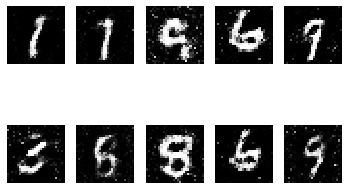

4200 loss_D 0.6473901 loss_G 0.8839371


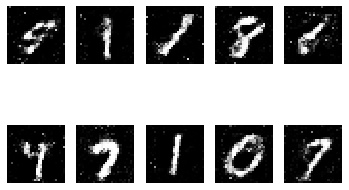

4300 loss_D 0.66885746 loss_G 0.8846854


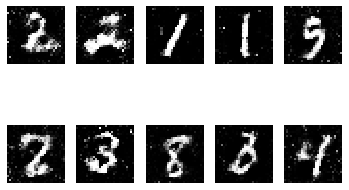

4400 loss_D 0.65574074 loss_G 0.85882705


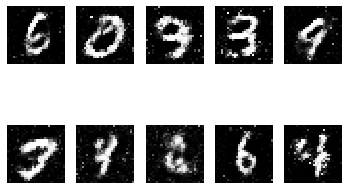

4500 loss_D 0.6566484 loss_G 0.85742825


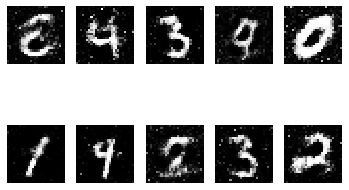

4600 loss_D 0.6808455 loss_G 0.8144223


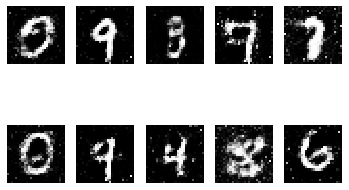

4700 loss_D 0.6463239 loss_G 0.89225066


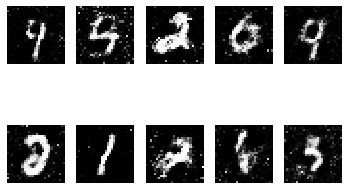

4800 loss_D 0.65187 loss_G 0.84926564


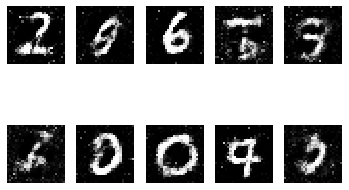

4900 loss_D 0.6384305 loss_G 0.9066656


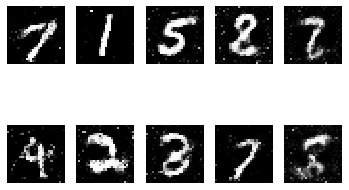

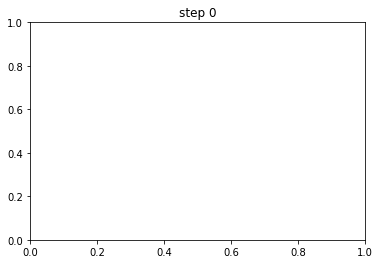

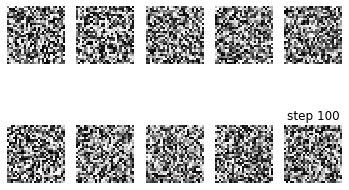

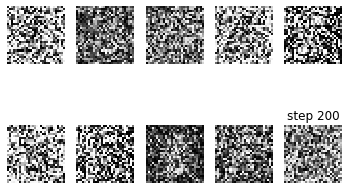

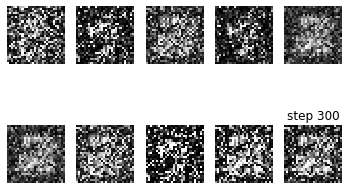

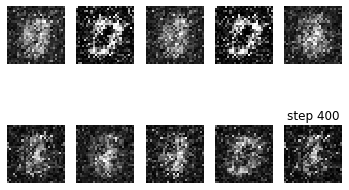

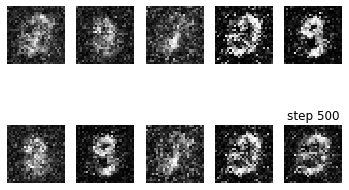

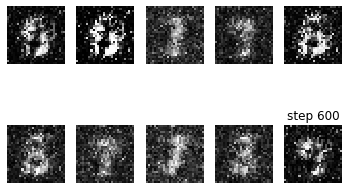

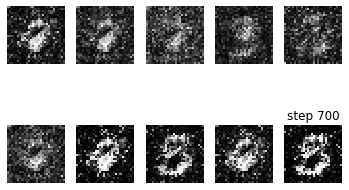

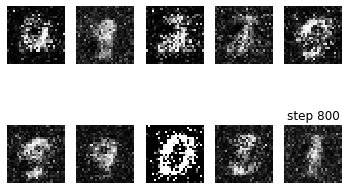

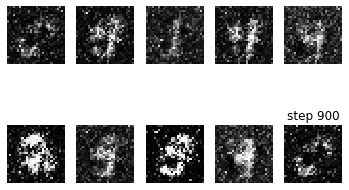

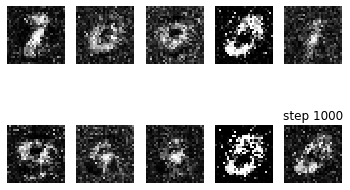

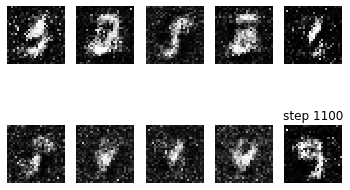

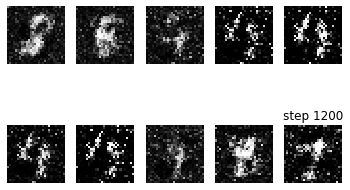

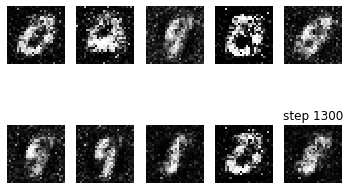

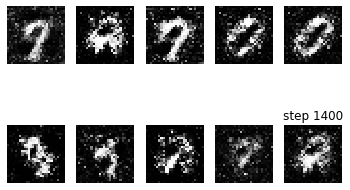

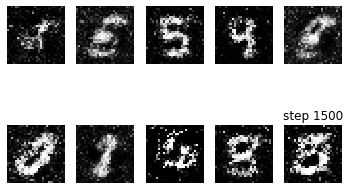

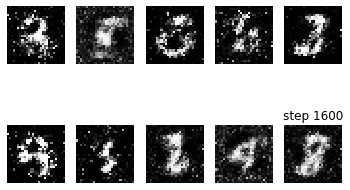

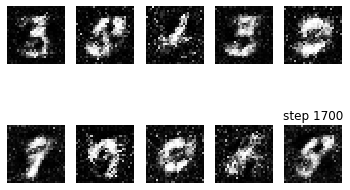

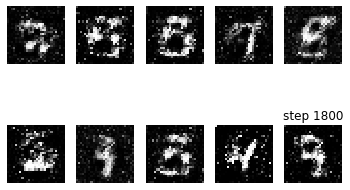

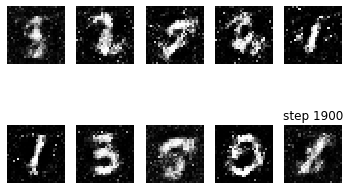

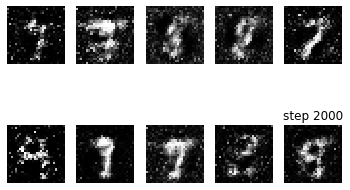

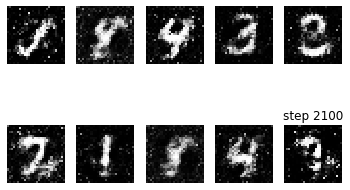

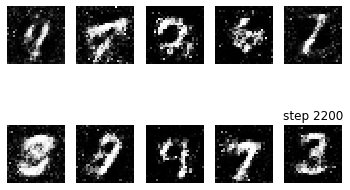

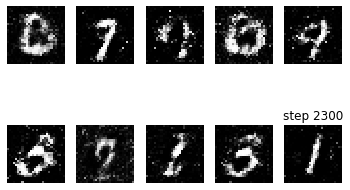

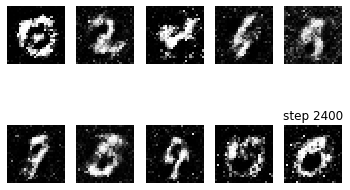

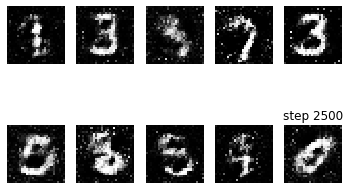

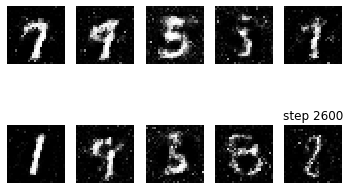

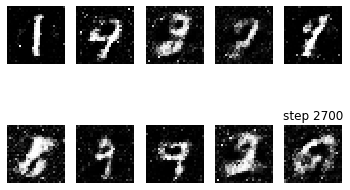

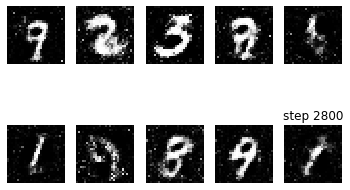

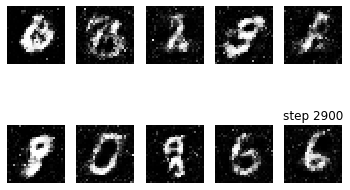

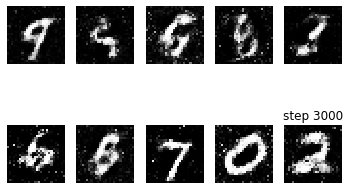

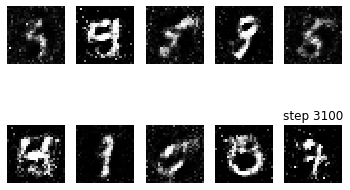

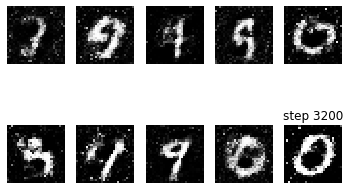

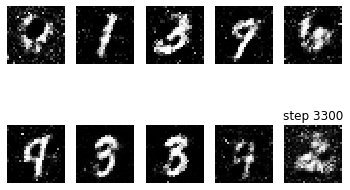

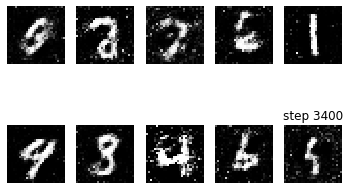

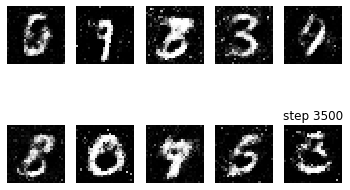

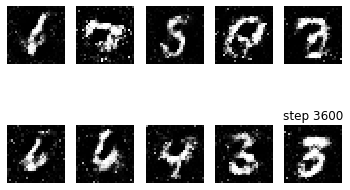

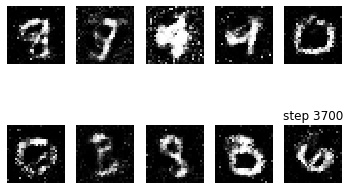

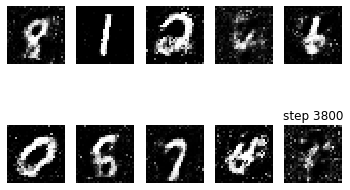

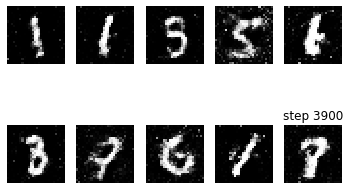

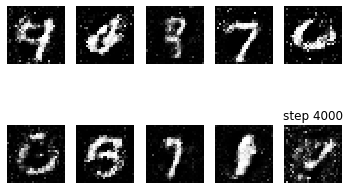

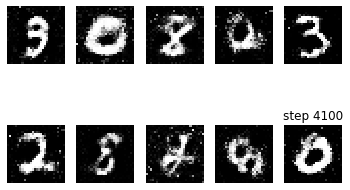

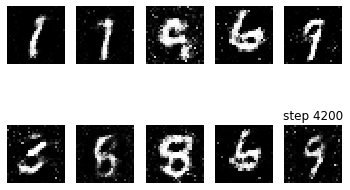

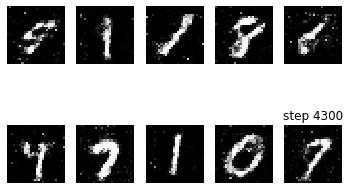

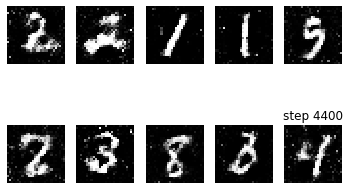

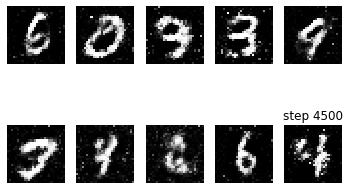

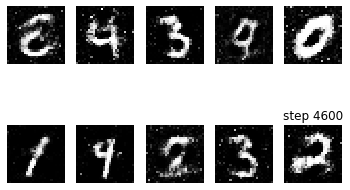

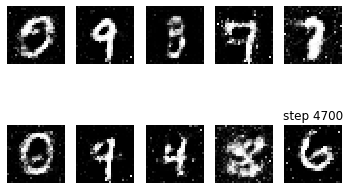

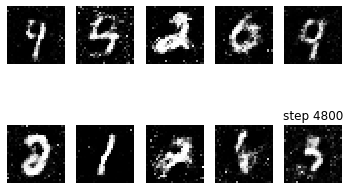

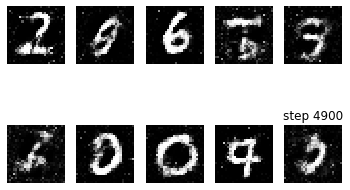

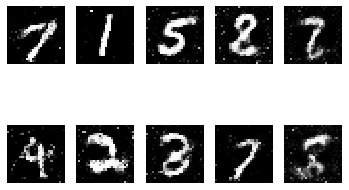

In [0]:
# G és D tanítása, kirajzolással

for step in range(5000):
    
  # képekből véletlen batch-nyi kiválasztása
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]
  
  
  # egy batch-nyi kép generálás
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)
  
  # diszkriminátor tanítása
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  
  # generátor tanítása
  g_loss = gan.combined.train_on_batch(noise, valid)
  
  # log
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    
  # generált képek kirajzolása
  if step % 100 == 0:
    plot_images(gan, step)
    

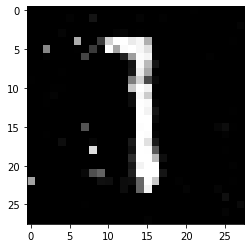

In [0]:
# 1 db digit generálása (többször ismételhető)
# esetleg össze lehet hasonlítani az előző VAE generált példával
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

In [0]:
# itt a vége.
# az alap GAN tehát ennyit tud: véletlen zaj alapján digiteket tud generálni,
# de azt nem tudjuk befolyásolni, hogy milyen digit legyen a képen